In [632]:
#*********************@Author: Aniruddh Khera*********************
# About the data: S&P500 companies stock prices from 2010-2016
# Here I analyzed for GOOGLE, we can do it for other
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import *
import theano
floatX = theano.config.floatX
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("nyse/prices-split-adjusted.csv")

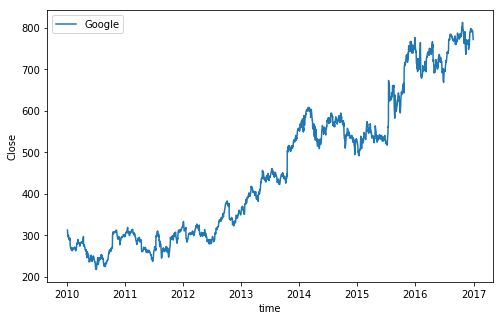

In [633]:
#**********************EXPLORATORY ANALYSIS**********************
#select google
goog = df[df.symbol == 'GOOG']
goog.date = goog.date.convert_objects(convert_dates='coerce')
goog = goog.sort_index(by="date")
goog = goog.set_index("date")
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(goog['close'], label='Google')
ax.set(xlabel='time', ylabel='Close')
ax.legend();


In [634]:
# Split data into training & testing
goog_train = goog[goog.index<'2016-12-14']
goog_test = goog[goog.index>='2016-12-14']

In [635]:
# Take log to make variance constant
goog_train['Log close'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_train['Log open'] = goog_train['open'].apply(lambda x: np.log(x))  
goog_train['Log low'] = goog_train['low'].apply(lambda x: np.log(x))  
goog_train['Log high'] = goog_train['high'].apply(lambda x: np.log(x)) 
goog_test['Log close'] = goog_test['close'].apply(lambda x: np.log(x))  
goog_test['Log open'] = goog_test['open'].apply(lambda x: np.log(x))  
goog_test['Log low'] = goog_test['low'].apply(lambda x: np.log(x))  
goog_test['Log high'] = goog_test['high'].apply(lambda x: np.log(x))  
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(goog_train[['Log close','Log open','Log low','Log high']]) 
goog_train[['Log close','Log open','Log low','Log high']]= scaled_values

scaled_values = scaler.fit_transform(goog_test[['Log close','Log open','Log low','Log high']]) 
goog_test[['Log close','Log open','Log low','Log high']]= scaled_values
scaled_value = scaler.fit_transform(goog_test[['close']])

#goog_train['Original Variance'] = pd.rolling_var(goog_train['close'], 30, min_periods=None, freq=None, center=True)  
#goog_train['Log Variance'] = pd.rolling_var(goog_train['close'], 30, min_periods=None, freq=None, center=True)

#fig, ax = plt.subplots(2, 1, figsize=(10, 5))  
#goog_train['Original Variance'].plot(ax=ax[0], title='Original Variance')  
#goog_train['Log Variance'].plot(ax=ax[1], title='Log Variance')  
#fig.tight_layout()

In [636]:
# Auto-regression
# We could use the AR API (not sure as they mentioned about innovation) to make our TS stationary but I prefered to build it myself as it's easier to understand &
# we already calculated the lagged/differenced for the ARIMA model

goog_train['lag2 close'] = goog_train['Log close'].shift(2) 

# cross-correlations (higest with respective lags)
goog_train['Log close'].corr(goog_train['Log open'].shift())
goog_train['Log close'].corr(goog_train['Log high'].shift())
goog_train['Log close'].corr(goog_train['Log low'].shift())

goog_train['lag open'] = goog_train['Log open'].shift()
goog_train['lag high'] = goog_train['Log high'].shift()
goog_train['lag low'] = goog_train['Log low'].shift()

df_touse = goog_train[['lag2 close','lag open', 'lag high', 'lag low', 'Log close']].iloc[2:]
trainX = df_touse[['lag2 close','lag open', 'lag high', 'lag low']]
trainY = df_touse[['Log close']]



#test construction

goog_test['lag2 close'] = goog_test['Log close'].shift(2) 
goog_test['lag open'] = goog_test['Log open'].shift()
goog_test['lag high'] = goog_test['Log high'].shift()
goog_test['lag low'] = goog_test['Log low'].shift()
first = goog_train.loc[goog_train.index == '2016-12-12']['Log close']
goog_test.ix['2016-12-14','lag2 close'] = first.iloc[0]
second = goog_train.loc[goog_train.index == '2016-12-13']['Log close']
goog_test.ix['2016-12-15','lag2 close'] = second.iloc[0]

first = goog_train.loc[goog_train.index == '2016-12-13']['Log open']
goog_test.ix['2016-12-14','lag open'] = first.iloc[0]
first = goog_train.loc[goog_train.index == '2016-12-13']['Log low']
goog_test.ix['2016-12-14','lag low'] = first.iloc[0]
first = goog_train.loc[goog_train.index == '2016-12-13']['Log high']
goog_test.ix['2016-12-14','lag high'] = first.iloc[0]

testX = goog_test[['lag2 close','lag open', 'lag high', 'lag low']]
testY = goog_test[['Log close']]

In [637]:
# Reference: http://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/ (Not used)
# Instead assumed the data represented by normal distribution
# Input: log open, log close, log high, log low (with lags)
# Output: Daily rolling based predictions
def construct_nn(ann_input, ann_output):   
    n_hidden =  5
    n_features = ann_input.get_value().shape[1]
    # Initialize random weights between each layer
    init_1 = np.random.randn(1, n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden,1).astype(floatX)   
    with pm.Model() as neural_network:
        
        weights_1 = pm.Normal('w_1', mu=0, sd=1, shape=(n_features, n_hidden), testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
        weights_3 = pm.Normal('w_3', mu=0, sd=1, shape=(n_hidden,1), testval=init_out)
        
        #Activations
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_2))
        act_3 = pm.math.sigmoid(pm.math.dot(act_2, weights_3))
        out = pm.Normal('out',act_3, observed=ann_output)
    return neural_network

ann_input = theano.shared(np.array(trainX))
ann_output = theano.shared(np.array(trainY))
neural_network = construct_nn(ann_input, ann_output)

In [638]:
with neural_network:
    trace = pm.sample(100, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 600/600 [01:00<00:00,  9.91it/s]


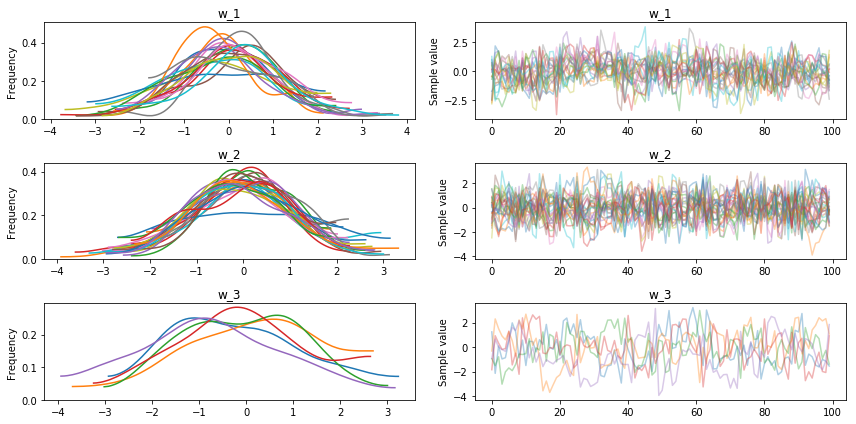

In [639]:
with neural_network:
    pm.traceplot(trace)

In [640]:
with neural_network:
    ppc = pm.sample_ppc(trace)

100%|██████████| 100/100 [00:00<00:00, 1011.84it/s]


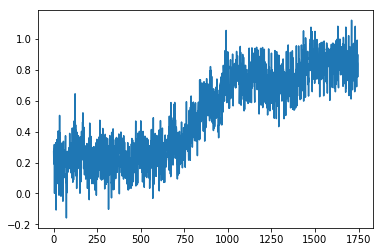

In [641]:
plt.plot(ppc['out'].mean(axis=0))

In [642]:
neural_network.out.distribution

In [643]:
import scipy.optimize
with neural_network:
    map_est = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)
    

logp = -1,666.9:   3%|▎         | 154/5000 [00:00<00:06, 697.14it/s]


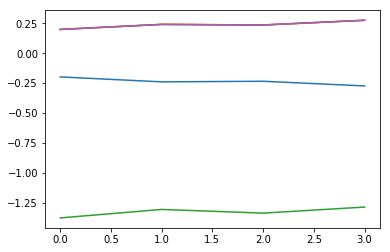

In [644]:
plt.plot(map_est['w_1'])

100%|██████████| 500/500 [00:00<00:00, 2993.60it/s]


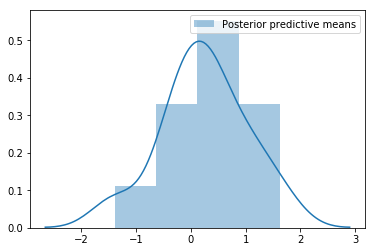

In [645]:
ann_input.set_value(testX)
with neural_network:    
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['out'].mean(axis=0)
    prob = ppc['out'].std(axis=0)
plt.figure()
ax = sb.distplot(ppc['out'][0], label='Posterior predictive means')
ax.legend()

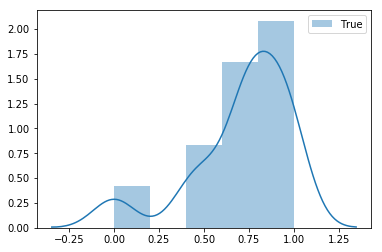

In [646]:
plt.figure()
ax = sb.distplot(testY, label='True')
ax.legend()

Text(0.5,1,'FORECAST RMSE: 4.6884')

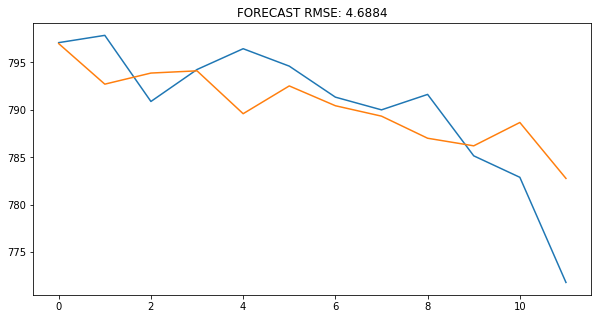

In [649]:
# Uncomment when required
# true = np.array(testY['Log close']).reshape(-1,1) 
# true = scaler.inverse_transform(true)
# pred = scaler.inverse_transform(pred)
# true = true.flatten()
# pred= pred.flatten()
pd.Series(true).plot(figsize=(10, 5))
pd.Series(pred).plot(figsize=(10, 5))
plt.title('FORECAST RMSE: %.4f'% np.sqrt(sum((pred-true)**2)/len(pred)))